## **Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('train_dataset.csv')
df_val  = pd.read_csv('validation_dataset.csv')

## **RoBERTa**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 125/125 [00:30<00:00,  4.09batch/s, val_loss=0.819]


Epoch 1:
  Train Loss: 0.9398
  Validation Loss: 0.8193
  Accuracy: 0.6500


Epoch 2/10: 100%|██████████| 125/125 [00:30<00:00,  4.09batch/s, val_loss=0.823]


Epoch 2:
  Train Loss: 0.7387
  Validation Loss: 0.8232
  Accuracy: 0.6660


Epoch 3/10: 100%|██████████| 125/125 [00:30<00:00,  4.08batch/s, val_loss=0.918]


Epoch 3:
  Train Loss: 0.5928
  Validation Loss: 0.9182
  Accuracy: 0.6510


Epoch 4/10: 100%|██████████| 125/125 [00:30<00:00,  4.09batch/s, val_loss=1.02]


Epoch 4:
  Train Loss: 0.4777
  Validation Loss: 1.0230
  Accuracy: 0.6590


Epoch 5/10: 100%|██████████| 125/125 [00:30<00:00,  4.09batch/s, val_loss=1.15]


Epoch 5:
  Train Loss: 0.3932
  Validation Loss: 1.1473
  Accuracy: 0.6660


Epoch 6/10: 100%|██████████| 125/125 [00:30<00:00,  4.09batch/s, val_loss=1.62]


Epoch 6:
  Train Loss: 0.3383
  Validation Loss: 1.6220
  Accuracy: 0.6510


Epoch 7/10: 100%|██████████| 125/125 [00:30<00:00,  4.08batch/s, val_loss=1.81]


Epoch 7:
  Train Loss: 0.2868
  Validation Loss: 1.8100
  Accuracy: 0.6720


Epoch 8/10: 100%|██████████| 125/125 [00:30<00:00,  4.08batch/s, val_loss=2.15]


Epoch 8:
  Train Loss: 0.2487
  Validation Loss: 2.1496
  Accuracy: 0.6560


Epoch 9/10: 100%|██████████| 125/125 [00:30<00:00,  4.08batch/s, val_loss=2.03]


Epoch 9:
  Train Loss: 0.2210
  Validation Loss: 2.0294
  Accuracy: 0.6450


Epoch 10/10: 100%|██████████| 125/125 [00:30<00:00,  4.08batch/s, val_loss=2.54]


Epoch 10:
  Train Loss: 0.1946
  Validation Loss: 2.5387
  Accuracy: 0.6370


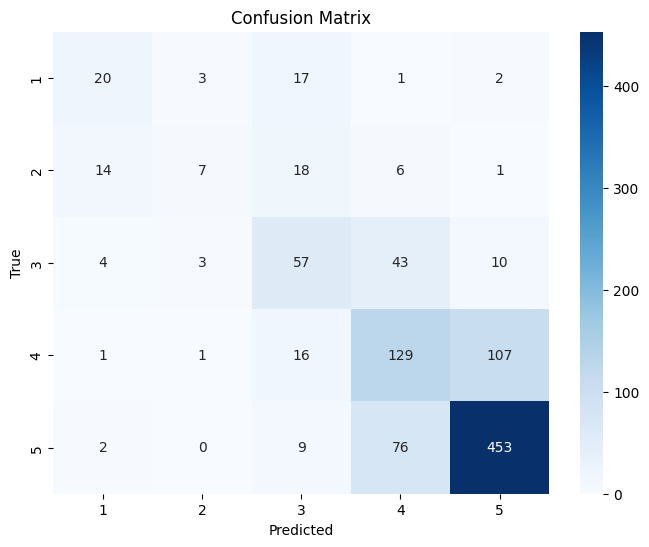

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting df
train_texts = df['reviewText'].tolist()  # Extracting 'reviewText' column
train_labels = df['overall'].tolist()    # Extracting 'overall' column

# Splitting df_val
val_texts = df_val['reviewText'].tolist()
val_labels = df_val['overall'].tolist()

# Load the pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define maximum sequence length
max_seq_length = 512  # Choose an appropriate value for your data

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings.input_ids),
                              torch.tensor(train_encodings.attention_mask),
                              torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_encodings.input_ids),
                            torch.tensor(val_encodings.attention_mask),
                            torch.tensor(val_labels))

# Define the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

# Store predictions and true labels for each epoch
all_val_preds_epoch = []
all_val_true_epoch = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_train:
        input_ids, attention_mask, labels = (t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar_train.set_postfix(train_loss=total_train_loss / len(progress_bar_train))

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_true = []
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids, attention_mask, labels = (t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_true.extend(labels.cpu().numpy())

            progress_bar_val.set_postfix(val_loss=total_val_loss / len(progress_bar_val))

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(all_val_true, all_val_preds)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')

    # Append predictions and true labels for each epoch
    all_val_preds_epoch.append(all_val_preds)
    all_val_true_epoch.append(all_val_true)


# Calculate confusion matrix for the second epoch (epoch index starts from 0)
epoch_index = 1  # Second epoch
conf_matrix = confusion_matrix(all_val_true_epoch[epoch_index], all_val_preds_epoch[epoch_index])

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Line Chart

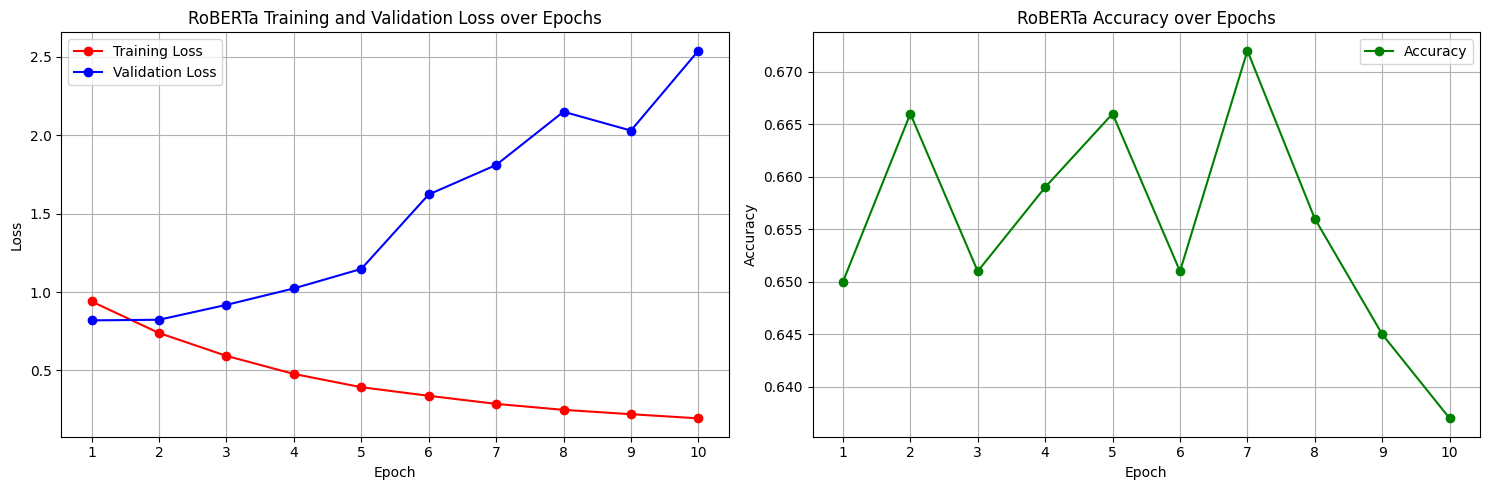

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, 11)
training_loss = [0.9398, 0.7387, 0.5928, 0.4777, 0.3932, 0.3383, 0.2868, 0.2487, 0.2210, 0.1946]
validation_loss = [0.8193, 0.8232, 0.9182, 1.0230, 1.1473, 1.6220, 1.8100, 2.1496, 2.0294, 2.5387]
accuracy = [0.6500, 0.6660, 0.6510, 0.6590, 0.6660, 0.6510, 0.6720, 0.6560, 0.6450, 0.6370]

# Plotting
plt.figure(figsize=(15, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, marker='o', label='Training Loss', color='red')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss', color='blue')
plt.title('RoBERTa Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')
plt.title('RoBERTa Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
